In [1]:
import geopandas as gpd
import requests
from PIL import Image as PILImage
from PIL import ImageChops
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO
from IPython.display import Image as IPyImage
import matplotlib.animation as animation
from scipy.ndimage import label
from matplotlib import cm
import matplotlib.lines as mlines
#

In [2]:
POLSKA_OBSZARY_BBOX = {
    'Warszawa': [2310981, 6808884, 2378018, 6875921],
    'Gdańsk': [2035020, 7200851, 2102057, 7267889],
    'Wrocław': [1861305, 6606825, 1928343, 6673863],
    'Poznań': [1851565, 6840188, 1918603, 6907225],
    'Rzeszów': [2412727, 6417097, 2479764, 6484135],
    'Lublin': [2478595, 6632117, 2545632, 6699154],
    'Szczecin': [1586491, 7029137, 1653528, 7096174],
    'Katowice': [2084613, 6458760, 2151650, 6525797],
    'Białystok': [2545620, 6974026, 2612657, 7041063],
    'Łódź': [2132313, 6723183, 2199350, 6790220]
}

EUROPA_OBSZARY_BBOX = {
    'Berlin': [1460889, 6858493, 1527927, 6925530],
    'Paryż': [226634, 6217370, 293672, 6284407],
    'Rzym': [1354356, 5112504, 1421394, 5179542],
    'Amsterdam': [512336, 6830972, 579373, 6898010],
    'Barcelona': [205595, 5036896, 272633, 5103934],
    'Praga': [1571797, 6428011, 1638834, 6495048],
    'Wiedeń': [1789204, 6108043, 1856241, 6175080],
    'Oslo': [1163410, 8347075, 1230447, 8414112],
    'Madryt': [-445823, 4893178, -378786, 4960215],
    'Lizbona': [-1051279, 4650536, -984242, 4717573],
    'Kopenhaga': [1365578, 7460686, 1432615, 7527723],
    'Bruksela': [450910, 6561337, 517947, 6628374]
}

In [3]:
area_name="Rzeszów"
bbox_values = POLSKA_OBSZARY_BBOX[area_name]
bbox = f"{bbox_values[0]},{bbox_values[1]},{bbox_values[2]},{bbox_values[3]}"
#area_name = [k for k, v in POLSKA_OBSZARY_BBOX.items() if v == bbox_values][0]

width_meters = bbox_values[2] - bbox_values[0]
height_meters = bbox_values[3] - bbox_values[1]
aspect_ratio = width_meters / height_meters

# Ustalmy bazową szerokość - jeśli bounding box nie jest kwadratem, to trzeba dopasować odpowiednio rozdzielczość
base_width = 2048
base_height = int(base_width / aspect_ratio) 
                  
params = {
    "bbox": bbox,
    "bboxSR": "102100",     # EPSG:3857 (Web Mercator)
    "imageSR": "102100",
    "size": f"{base_width},{base_height}",    # rozdzielczość
    "format": "png",        # 'jpg', 'tiff'
    "f": "image"
}

base_url = "https://image.discomap.eea.europa.eu/arcgis/rest/services/Corine/CLC{}_WM/MapServer/export"
years = [1990,2000,2006,2012,2018]
images = {}

# ściągamy plik dla każdego dostępnego roku
for year in years:
    print(base_url.format(year))
    response = requests.get(base_url.format(year), params=params)
    print(f"Obraz dla roku {year} wczytany")
    image = PILImage.open(BytesIO(response.content))
    images[year] = image
print("Pobrano wszystkie obrazy.")


https://image.discomap.eea.europa.eu/arcgis/rest/services/Corine/CLC1990_WM/MapServer/export
Obraz dla roku 1990 wczytany
https://image.discomap.eea.europa.eu/arcgis/rest/services/Corine/CLC2000_WM/MapServer/export
Obraz dla roku 2000 wczytany
https://image.discomap.eea.europa.eu/arcgis/rest/services/Corine/CLC2006_WM/MapServer/export
Obraz dla roku 2006 wczytany
https://image.discomap.eea.europa.eu/arcgis/rest/services/Corine/CLC2012_WM/MapServer/export
Obraz dla roku 2012 wczytany
https://image.discomap.eea.europa.eu/arcgis/rest/services/Corine/CLC2018_WM/MapServer/export
Obraz dla roku 2018 wczytany
Pobrano wszystkie obrazy.


In [4]:
# Słownik z obrazami
images.items()

dict_items([(1990, <PIL.PngImagePlugin.PngImageFile image mode=P size=2048x2048 at 0x1DC69E6A1D0>), (2000, <PIL.PngImagePlugin.PngImageFile image mode=P size=2048x2048 at 0x1DC6A097590>), (2006, <PIL.PngImagePlugin.PngImageFile image mode=P size=2048x2048 at 0x1DC6874E990>), (2012, <PIL.PngImagePlugin.PngImageFile image mode=P size=2048x2048 at 0x1DC68488510>), (2018, <PIL.PngImagePlugin.PngImageFile image mode=P size=2048x2048 at 0x1DC6A0360D0>)])

In [5]:
level_3_legend = {
    (230, 0, 77): "111 - Zwarta zabudowa miejska",
    (255, 0, 0): "112 - Rozproszona zabudowa miejska",
    (204, 77, 242): "121 - Obszary przemysłowe i handlowe",
    (204, 0, 0): "122 - Sieci drogowe i kolejowe oraz powiązane tereny",
    (230, 204, 204): "123 - Obszary portowe",
    (230, 204, 230): "124 - Lotniska",
    (166, 0, 204): "131 - Tereny wydobycia surowców",
    (166, 77, 0): "132 - Wysypiska",
    (255, 77, 255): "133 - Place budowy",
    (255, 166, 255): "141 - Zielone obszary miejskie",
    (255, 230, 255): "142 - Obiekty sportowe i rekreacyjne",
    (255, 255, 168): "211 - Grunty orne nieirygowane",
    (255, 255, 0): "212 - Grunty orne nawadniane",
    (230, 230, 0): "213 - Pola ryżowe",
    (230, 128, 0): "221 - Winnice",
    (242, 166, 77): "222 - Sady i plantacje owoców jagodowych",
    (230, 166, 0): "223 - Gaje oliwne",
    (230, 230, 77): "231 - Pastwiska",
    (255, 230, 166): "241 - Uprawy jednoroczne powiązane z uprawami trwałymi",
    (255, 230, 77): "242 - Złożone wzorce upraw",
    (230, 204, 77): "243 - Obszary rolnicze z naturalną roślinnością",
    (242, 204, 166): "244 - Obszary agro-leśne",
    (128, 255, 0): "311 - Lasy liściaste",
    (0, 166, 0): "312 - Lasy iglaste",
    (77, 255, 0): "313 - Lasy mieszane",
    (204, 242, 77): "321 - Naturalne trawiaste obszary",
    (166, 255, 128): "322 - Wrzośce i wrzosowiska",
    (166, 230, 77): "323 - Roślinność twardolistna",
    (166, 242, 0): "324 - Przejściowe formy lasu i zarośli",
    (230, 230, 230): "331 - Plaże, wydmy, piaski",
    (204, 204, 204): "332 - Skały lite",
    (204, 255, 204): "333 - Obszary słabo roślinne",
    (0, 0, 0): "334 - Obszary spalone",
    (166, 230, 204): "335 - Lodowce i wieczne śniegi",
    (166, 166, 255): "411 - Bagna śródlądowe",
    (77, 77, 255): "412 - Torfowiska",
    (204, 204, 255): "421 - Słone bagna",
    (230, 230, 255): "422 - Saliny",
    (166, 166, 230): "423 - Płaskie wybrzeża zalewowe",
    (0, 204, 242): "511 - Rzeki",
    (128, 242, 230): "512 - Zbiorniki wodne",
    (0, 255, 166): "521 - Laguny przybrzeżne",
    (166, 255, 230): "522 - Estuaria",
    (230, 242, 255): "523 - Morza i oceany",
    (230, 242, 255): "No Data - Brak danych"
}

level_2_legend = {
    (230, 0, 77): "11 - Zabudowa miejska",
    (204, 77, 242): "12 - Obiekty przemysłowe, handlowe i transportowe",
    (166, 0, 204): "13 - Tereny górnicze, hałdy i place budowy",
    (255, 166, 255): "14 - Sztuczna roślinność nie-rolnicza",
    (255, 255, 168): "21 - Grunty orne",
    (230, 128, 0): "22 - Uprawy trwałe",
    (230, 230, 77): "23 - Użytki zielone",
    (255, 230, 166): "24 - Złożone obszary rolnicze",
    (128, 255, 0): "31 - Lasy",
    (204, 242, 77): "32 - Zarośla i roślinność trawiasta",
    (230, 230, 230): "33 - Tereny odkryte z małą lub żadną roślinnością",
    (166, 166, 255): "41 - Śródlądowe obszary podmokłe",
    (204, 204, 255): "42 - Nadmorskie obszary podmokłe",
    (0, 204, 242): "51 - Wody śródlądowe",
    (0, 255, 166): "52 - Wody morskie",
    (230, 242, 255): "No Data - Brak danych"
}

level_2_legend_rgb = {v.split(" - ")[0]: k for k, v in level_2_legend.items()}
level_2_legend_desc = {v.split(" - ")[0]: v for v in level_2_legend.values()}

level_1_legend = {
    (230, 0, 77): "1 - Sztuczne powierzchnie",
    (255, 255, 168): "2 - Użytki rolne",
    (128, 255, 0): "3 - Lasy i tereny półnaturalne",
    (166, 166, 255): "4 - Obszary podmokłe",
    (0, 204, 242): "5 - Ciała wodne",
    (230, 242, 255): "No Data - Brak danych"
}

level_1_legend_rgb = {v.split(" - ")[0]: k for k, v in level_1_legend.items()}
level_1_legend_desc = {v.split(" - ")[0]: v for v in level_1_legend.values()}

In [6]:
#level_1_legend - (wartości rgb) : <numer> - <nazwa_terenu>
#level_1_legend_rgb - <numer> : (wartości rgb)
#level_1_legend_desc - <numer> : <numer> - <nazwa_terenu>

In [7]:
level_1_legend

{(230, 0, 77): '1 - Sztuczne powierzchnie',
 (255, 255, 168): '2 - Użytki rolne',
 (128, 255, 0): '3 - Lasy i tereny półnaturalne',
 (166, 166, 255): '4 - Obszary podmokłe',
 (0, 204, 242): '5 - Ciała wodne',
 (230, 242, 255): 'No Data - Brak danych'}

In [8]:
level_1_legend_rgb

{'1': (230, 0, 77),
 '2': (255, 255, 168),
 '3': (128, 255, 0),
 '4': (166, 166, 255),
 '5': (0, 204, 242),
 'No Data': (230, 242, 255)}

In [9]:
level_1_legend_desc

{'1': '1 - Sztuczne powierzchnie',
 '2': '2 - Użytki rolne',
 '3': '3 - Lasy i tereny półnaturalne',
 '4': '4 - Obszary podmokłe',
 '5': '5 - Ciała wodne',
 'No Data': 'No Data - Brak danych'}

## Wartości dla kolejnych lat 


In [11]:
dfs = {}  

for year, img in images.items():
    img = img.convert("RGB")
    img_array = np.array(img)

    height, width, _ = img_array.shape

    pixels = img_array.reshape(-1, 3)
    rows = np.repeat(np.arange(height), width)
    cols = np.tile(np.arange(width), height)

    df = pd.DataFrame({
        'x': cols,
        'y': rows,
        'R': pixels[:, 0],
        'G': pixels[:, 1],
        'B': pixels[:, 2]
    })

    dfs[year] = df  
    print(f"DataFrame dla roku {year} utworzony.")

print(dfs[1990])

DataFrame dla roku 1990 utworzony.
DataFrame dla roku 2000 utworzony.
DataFrame dla roku 2006 utworzony.
DataFrame dla roku 2012 utworzony.
DataFrame dla roku 2018 utworzony.
            x     y    R    G    B
0           0     0  255    0    0
1           1     0  255    0    0
2           2     0  255    0    0
3           3     0  255  255  168
4           4     0  255  255  168
...       ...   ...  ...  ...  ...
4194299  2043  2047  255  255  168
4194300  2044  2047  255  255  168
4194301  2045  2047  255  255  168
4194302  2046  2047  255  255  168
4194303  2047  2047  255  255  168

[4194304 rows x 5 columns]


In [12]:
# Zliczenia poszczególnych klas
class_counts_per_year = {}
class_lvl_2_counts_per_year = {}
class_lvl_1_counts_per_year = {}

for year, df in dfs.items():
    df["rgb"] = list(zip(df["R"], df["G"], df["B"]))
    df["class"] = df["rgb"].map(level_3_legend).fillna("Nieznana")

    df["class_lvl_2"] = df["class"].str[:2]
    df["rgb_lvl_2"] = df["class_lvl_2"].map(level_2_legend_rgb)
    df["class_lvl_2"] = df["class_lvl_2"].map(level_2_legend_desc)
    df['rgb_lvl_2_norm'] = df['rgb_lvl_2'].apply(lambda rgb: tuple([v / 255 for v in rgb]))

    df["class_lvl_1"] = df["class"].str[0]
    df["rgb_lvl_1"] = df["class_lvl_1"].map(level_1_legend_rgb)
    df["class_lvl_1"] = df["class_lvl_1"].map(level_1_legend_desc)
    df['rgb_lvl_1_norm'] = df['rgb_lvl_1'].apply(lambda rgb: tuple([v / 255 for v in rgb]))
    
    class_counts = df["class"].value_counts()
    class_counts_per_year[year] = class_counts

    class_lvl_2_counts = df["class_lvl_2"].value_counts()
    class_lvl_2_counts_per_year[year] = class_lvl_2_counts

    class_lvl_1_counts = df["class_lvl_1"].value_counts()
    class_lvl_1_counts_per_year[year] = class_lvl_1_counts

In [13]:
print(f"Zliczenia klas dla roku 1990:")
print(class_counts_per_year[1990])

Zliczenia klas dla roku 1990:
class
211 - Grunty orne nieirygowane                          1769972
242 - Złożone wzorce upraw                               559934
243 - Obszary rolnicze z naturalną roślinnością          461542
313 - Lasy mieszane                                      459024
312 - Lasy iglaste                                       239199
231 - Pastwiska                                          238776
112 - Rozproszona zabudowa miejska                       223341
311 - Lasy liściaste                                     178486
121 - Obszary przemysłowe i handlowe                      17980
142 - Obiekty sportowe i rekreacyjne                      16346
222 - Sady i plantacje owoców jagodowych                   9275
324 - Przejściowe formy lasu i zarośli                     6652
512 - Zbiorniki wodne                                      6394
131 - Tereny wydobycia surowców                            2626
141 - Zielone obszary miejskie                             1927
122 

In [14]:
print(f"\nZliczenia klas 2 poziomu dla roku 1990:")
print(class_lvl_2_counts_per_year[1990])


Zliczenia klas 2 poziomu dla roku 1990:
class_lvl_2
21 - Grunty orne                                     1769972
24 - Złożone obszary rolnicze                        1021476
31 - Lasy                                             876709
23 - Użytki zielone                                   238776
11 - Zabudowa miejska                                 223341
12 - Obiekty przemysłowe, handlowe i transportowe      19488
14 - Sztuczna roślinność nie-rolnicza                  18273
22 - Uprawy trwałe                                      9275
32 - Zarośla i roślinność trawiasta                     6652
51 - Wody śródlądowe                                    6394
13 - Tereny górnicze, hałdy i place budowy              3948
Name: count, dtype: int64


In [15]:
print(f"\nZliczenia klas 1 poziomu dla roku 1990:")
print(class_lvl_1_counts_per_year[1990])


Zliczenia klas 1 poziomu dla roku 1990:
class_lvl_1
2 - Użytki rolne                  3039499
3 - Lasy i tereny półnaturalne     883361
1 - Sztuczne powierzchnie          265050
5 - Ciała wodne                      6394
Name: count, dtype: int64


In [16]:
# procentowy udział
class_percentage_per_year = {}
class_lvl_2_percentage_per_year = {}
class_lvl_1_percentage_per_year = {}

for year, df in dfs.items():
    df["rgb"] = list(zip(df["R"], df["G"], df["B"]))
    df["class"] = df["rgb"].map(level_3_legend).fillna("Nieznana")
    
    class_percentage = df["class"].value_counts(normalize=True) * 100
    class_percentage_per_year[year] = class_percentage

    class_lvl_2_percentage = df["class_lvl_2"].value_counts(normalize=True) * 100
    class_lvl_2_percentage_per_year[year] = class_lvl_2_percentage

    class_lvl_1_percentage = df["class_lvl_1"].value_counts(normalize=True) * 100
    class_lvl_1_percentage_per_year[year] = class_lvl_1_percentage

In [17]:
print(f"Procentowy udział klas dla roku 1990:")
print(class_percentage_per_year[1990])

Procentowy udział klas dla roku 1990:
class
211 - Grunty orne nieirygowane                          42.199421
242 - Złożone wzorce upraw                              13.349867
243 - Obszary rolnicze z naturalną roślinnością         11.004019
313 - Lasy mieszane                                     10.943985
312 - Lasy iglaste                                       5.702949
231 - Pastwiska                                          5.692863
112 - Rozproszona zabudowa miejska                       5.324864
311 - Lasy liściaste                                     4.255438
121 - Obszary przemysłowe i handlowe                     0.428677
142 - Obiekty sportowe i rekreacyjne                     0.389719
222 - Sady i plantacje owoców jagodowych                 0.221133
324 - Przejściowe formy lasu i zarośli                   0.158596
512 - Zbiorniki wodne                                    0.152445
131 - Tereny wydobycia surowców                          0.062609
141 - Zielone obszary miejskie  

In [18]:
print(f"\nProcentowy udział klas 2 poziomu dla roku 1990:")
print(class_lvl_2_percentage_per_year[1990])


Procentowy udział klas 2 poziomu dla roku 1990:
class_lvl_2
21 - Grunty orne                                     42.199421
24 - Złożone obszary rolnicze                        24.353886
31 - Lasy                                            20.902371
23 - Użytki zielone                                   5.692863
11 - Zabudowa miejska                                 5.324864
12 - Obiekty przemysłowe, handlowe i transportowe     0.464630
14 - Sztuczna roślinność nie-rolnicza                 0.435662
22 - Uprawy trwałe                                    0.221133
32 - Zarośla i roślinność trawiasta                   0.158596
51 - Wody śródlądowe                                  0.152445
13 - Tereny górnicze, hałdy i place budowy            0.094128
Name: proportion, dtype: float64


In [19]:
print(f"\nProcentowy udział klas 1 poziomu dla roku 1990:")
print(class_lvl_1_percentage_per_year[1990])


Procentowy udział klas 1 poziomu dla roku 1990:
class_lvl_1
2 - Użytki rolne                  72.467303
3 - Lasy i tereny półnaturalne    21.060967
1 - Sztuczne powierzchnie          6.319284
5 - Ciała wodne                    0.152445
Name: proportion, dtype: float64


In [20]:
unique_categories_per_year = {}
unique_categories_lvl_2_per_year = {}
unique_categories_lvl_1_per_year = {}

for year, df in dfs.items():
    df["rgb"] = list(zip(df["R"], df["G"], df["B"]))
    
    unique_rgb_values = set(df["rgb"].unique())
    unique_rgb_values_lvl_2 = set(df["rgb_lvl_2"].unique())
    unique_rgb_values_lvl_1 = set(df["rgb_lvl_1"].unique())
    
    unique_categories = {key: value for key, value in level_3_legend.items() if key in unique_rgb_values}
    unique_categories_per_year[year] = unique_categories

    unique_categories_lvl_2 = {key: value for key, value in level_2_legend.items() if key in unique_rgb_values_lvl_2}
    unique_categories_lvl_2_per_year[year] = unique_categories_lvl_2

    unique_categories_lvl_1 = {key: value for key, value in level_1_legend.items() if key in unique_rgb_values_lvl_1}
    unique_categories_lvl_1_per_year[year] = unique_categories_lvl_1

In [21]:
print(f"Liczba uniklanych kategorii poziomu 3 dla roku 1990:")
print(len(unique_categories_per_year[1990]))

Liczba uniklanych kategorii poziomu 3 dla roku 1990:
17


In [22]:
print(f"\nLiczba uniklanych kategorii poziomu 2 dla roku 1990:")
print(len(unique_categories_lvl_2_per_year[1990]))


Liczba uniklanych kategorii poziomu 2 dla roku 1990:
11


In [23]:
print(f"\nLiczba uniklanych kategorii poziomu 1 dla roku 1990:")
print(len(unique_categories_lvl_1_per_year[1990]))


Liczba uniklanych kategorii poziomu 1 dla roku 1990:
4


## Opis wszystkich obliczonych zmiennych

In [25]:
dfs[1990]

,x,y,R,G,B,rgb,class,class_lvl_2,rgb_lvl_2,rgb_lvl_2_norm,class_lvl_1,rgb_lvl_1,rgb_lvl_1_norm
0,0,0,255,0,0,"(255, 0, 0)",112 - Rozproszona zabudowa miejska,11 - Zabudowa miejska,"(230, 0, 77)","(0.9019607843137255, 0.0, 0.30196078431372547)",1 - Sztuczne powierzchnie,"(230, 0, 77)","(0.9019607843137255, 0.0, 0.30196078431372547)"
1,1,0,255,0,0,"(255, 0, 0)",112 - Rozproszona zabudowa miejska,11 - Zabudowa miejska,"(230, 0, 77)","(0.9019607843137255, 0.0, 0.30196078431372547)",1 - Sztuczne powierzchnie,"(230, 0, 77)","(0.9019607843137255, 0.0, 0.30196078431372547)"
2,2,0,255,0,0,"(255, 0, 0)",112 - Rozproszona zabudowa miejska,11 - Zabudowa miejska,"(230, 0, 77)","(0.9019607843137255, 0.0, 0.30196078431372547)",1 - Sztuczne powierzchnie,"(230, 0, 77)","(0.9019607843137255, 0.0, 0.30196078431372547)"
3,3,0,255,255,168,"(255, 255, 168)",211 - Grunty orne nieirygowane,21 - Grunty orne,"(255, 255, 168)","(1.0, 1.0, 0.6588235294117647)",2 - Użytki rolne,"(255, 255, 168)","(1.0, 1.0, 0.6588235294117647)"
4,4,0,255,255,168,"(255, 255, 168)",211 - Grunty orne nieirygowane,21 - Grunty orne,"(255, 255, 168)","(1.0, 1.0, 0.6588235294117647)",2 - Użytki rolne,"(255, 255, 168)","(1.0, 1.0, 0.6588235294117647)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4194299,2043,2047,255,255,168,"(255, 255, 168)",211 - Grunty orne nieirygowane,21 - Grunty orne,"(255, 255, 168)","(1.0, 1.0, 0.6588235294117647)",2 - Użytki rolne,"(255, 255, 168)","(1.0, 1.0, 0.6588235294117647)"
4194300,2044,2047,255,255,168,"(255, 255, 168)",211 - Grunty orne nieirygowane,21 - Grunty orne,"(255, 255, 168)","(1.0, 1.0, 0.6588235294117647)",2 - Użytki rolne,"(255, 255, 168)","(1.0, 1.0, 0.6588235294117647)"
4194301,2045,2047,255,255,168,"(255, 255, 168)",211 - Grunty orne nieirygowane,21 - Grunty orne,"(255, 255, 168)","(1.0, 1.0, 0.6588235294117647)",2 - Użytki rolne,"(255, 255, 168)","(1.0, 1.0, 0.6588235294117647)"
4194302,2046,2047,255,255,168,"(255, 255, 168)",211 - Grunty orne nieirygowane,21 - Grunty orne,"(255, 255, 168)","(1.0, 1.0, 0.6588235294117647)",2 - Użytki rolne,"(255, 255, 168)","(1.0, 1.0, 0.6588235294117647)"


dfs to słownik zawierający dataframe dla każdego roku. Posiada on następujące kolumny:
* lp - liczba porządkowa
* x - pozycja piksela na osi x
* y - pozycja piksela na osi y
* R - wartość kanału czerwieni 0-255
* G - wartość kanału zieleni 0-255
* B - wartość kanału niebieskiego 0-255
* rgb - kolor piksela dla klasy 3 (R,G,B)
* class - klasa poziomu 3 \<numer\> - \<nazwa\>
* class_lvl_2 - klasa poziomu 2 \<numer\> - \<nazwa\>
* rgb_lvl_2	- kolor piksela dla klasy 2 (R,G,B)
* rgb_lvl_2_norm - kolor piksela dla klasy 2 znormalizowany
* class_lvl_1 - klasa poziomu 1 \<numer\> - \<klasa\>
* rgb_lvl_1 - kolor piksela dla klasy 1 (R,G,B)
* rgb_lvl_1_norm - kolor piksela dla klasy 1 znormalizowany

class_counts_per_year - słownik zawierający dla każdego roku pandas Series ze zliczeniami klas poziomu 3
class_lvl_2_counts_per_year - słownik zawierający dla każdego roku pandas Series ze zliczeniami klas poziomu 2
class_lvl_1_counts_per_year - słownik zawierający dla każdego roku pandas Series ze zliczeniami klas poziomu 1

class_percentage_per_year - słownik zawierający dla każdego roku pandas Series z procentowym udziałem klas poziomu 3
class_lvl_2_percentage_per_year - słownik zawierający dla każdego roku pandas Series z procentowym udziałem klas poziomu 2
class_lvl_1_percentage_per_year - słownik zawierający dla każdego roku pandas Series z procentowym udziałem klas poziomu 1

unique_categories_per_year - słownik, zawierający dla każdego roku słownik z legendą terenów 3 poziomu znajdujących się na zdjęciu (R,G,B) - nazwa terenu wraz z numerem

unique_categories_lvl_2_per_year - słownik, zawierający dla każdego roku słownik z legendą terenów 2 poziomu znajdujących się na zdjęciu (R,G,B) - nazwa terenu wraz z numerem

unique_categories_lvl_1_per_year - słownik, zawierający dla każdego roku słownik z legendą terenów 1 poziomu znajdujących się na zdjęciu (R,G,B) - nazwa terenu wraz z numerem

images - słownik rok : obraz dla danego roku

## Utworzenie obrazów dla 2 i 1 kategorii

In [30]:
def generate_image_dict_from_dfs(dfs, rgb_column):
    images = {}

    for year, df in dfs.items():
        width = df['x'].max() + 1
        height = df['y'].max() + 1

        image_array = np.zeros((height, width, 3), dtype=np.uint8)
        rgb = np.stack(df[rgb_column].to_numpy())
        x = df['x'].to_numpy()
        y = df['y'].to_numpy()

        image_array[y, x] = rgb
        image = PILImage.fromarray(image_array, mode='RGB')
        images[year] = image

        print(f'Obraz dla roku {year} ({rgb_column}) utworzony.')

    return images

In [31]:
images_lvl_1 = generate_image_dict_from_dfs(dfs, rgb_column='rgb_lvl_1')
images_lvl_2 = generate_image_dict_from_dfs(dfs, rgb_column='rgb_lvl_2')

Obraz dla roku 1990 (rgb_lvl_1) utworzony.
Obraz dla roku 2000 (rgb_lvl_1) utworzony.
Obraz dla roku 2006 (rgb_lvl_1) utworzony.
Obraz dla roku 2012 (rgb_lvl_1) utworzony.
Obraz dla roku 2018 (rgb_lvl_1) utworzony.
Obraz dla roku 1990 (rgb_lvl_2) utworzony.
Obraz dla roku 2000 (rgb_lvl_2) utworzony.
Obraz dla roku 2006 (rgb_lvl_2) utworzony.
Obraz dla roku 2012 (rgb_lvl_2) utworzony.
Obraz dla roku 2018 (rgb_lvl_2) utworzony.


In [32]:
images_lvl_3 = generate_image_dict_from_dfs(dfs, rgb_column='rgb')

Obraz dla roku 1990 (rgb) utworzony.
Obraz dla roku 2000 (rgb) utworzony.
Obraz dla roku 2006 (rgb) utworzony.
Obraz dla roku 2012 (rgb) utworzony.
Obraz dla roku 2018 (rgb) utworzony.


## Wyświetlenie map dla wszytkich lat 

In [34]:
def MapAnimationByYears(images_dict, legend_dict_per_year, area_name, level_name, save_as_gif=True, fps=1):
    years = list(images_dict.keys())

    fig, (ax_map, ax_legend) = plt.subplots(ncols=2, figsize=(10, 5),gridspec_kw={'width_ratios': [3, 1]})

    def update(frame):
        ax_map.clear()
        ax_legend.clear()

        year = years[frame]
        pil_img = images_dict[year]
        img = np.array(pil_img)
        year_legend = legend_dict_per_year[year]

        # Mapa
        ax_map.imshow(img)
        ax_map.axis("off")
        title = area_name.replace("_", " ").title()
        ax_map.set_title(f"Mapa użytkowania terenu poziom {level_name} - {title} ({year})")

        # Legenda
        ax_legend.axis("off")
        ax_legend.set_title("Legenda", fontsize=12, fontweight='bold')

        legend_patches = [
            plt.Line2D(
                [0], [0],
                marker='o',
                color='w',
                markersize=10,
                markerfacecolor=np.array(rgb) / 255.0,
                label=label
            )
            for rgb, label in year_legend.items()
        ]

        ax_legend.legend(
            handles=legend_patches,
            loc="upper left",
            fontsize=9,
            frameon=False
        )

    ani = animation.FuncAnimation(
        fig, update,
        frames=len(years),
        interval=int(1000 / fps),
        repeat=True,
        blit=False
    )

    gif_filename = f"animacja_mapy_{level_name}.gif"
    if save_as_gif:
        ani.save(gif_filename, writer="pillow", fps=fps)
        plt.close(fig)
        return IPyImage(filename=gif_filename)
    else:
        return ani


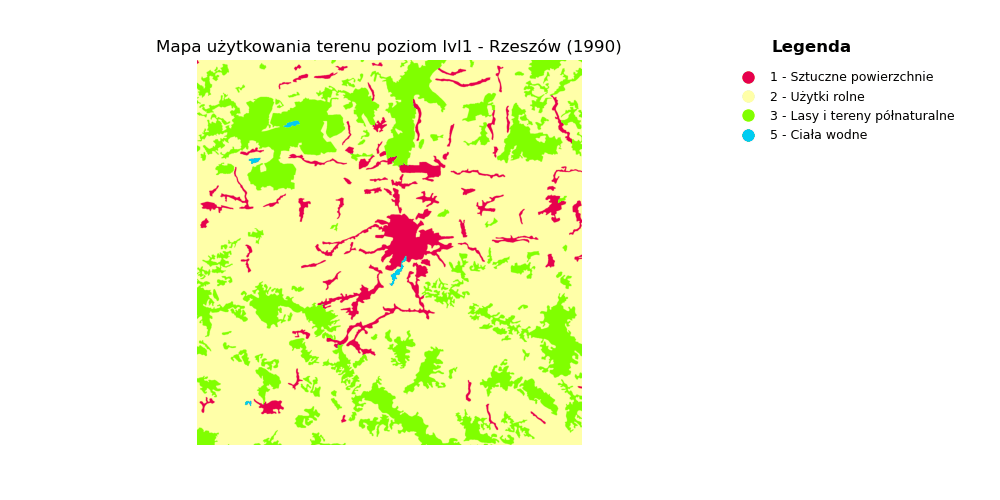

In [35]:
MapAnimationByYears(images_lvl_1, unique_categories_lvl_1_per_year, area_name, "lvl1")

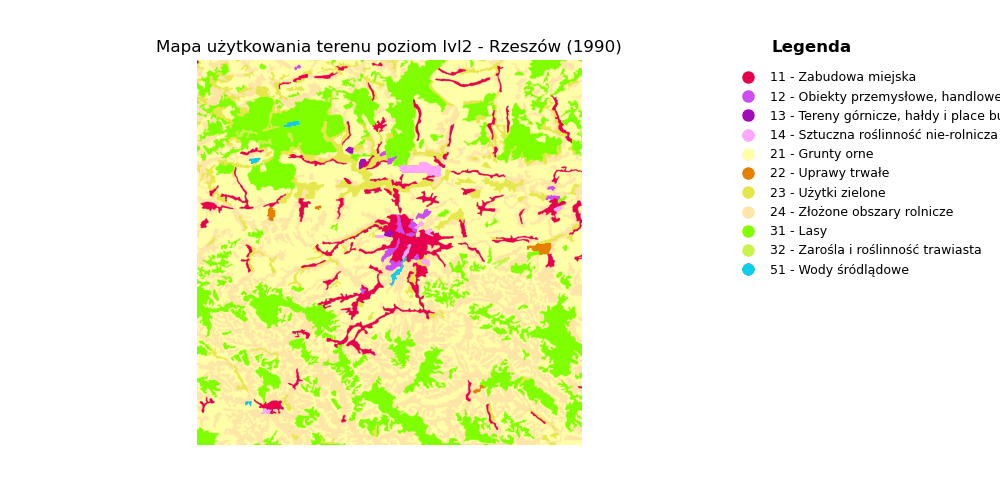

In [36]:
MapAnimationByYears(images_lvl_2, unique_categories_lvl_2_per_year, area_name, "lvl2")

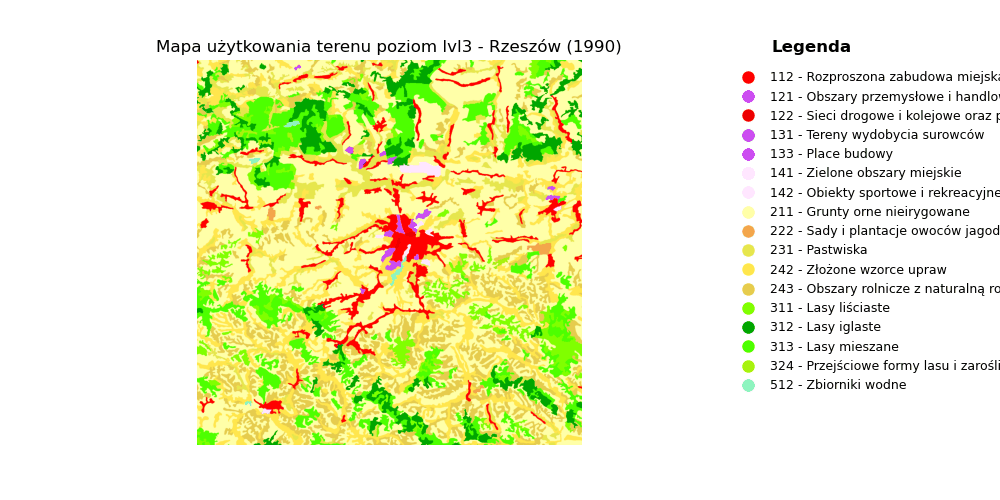

In [37]:
MapAnimationByYears(images_lvl_3, unique_categories_per_year, area_name, "lvl3")

## Zmiany terenu

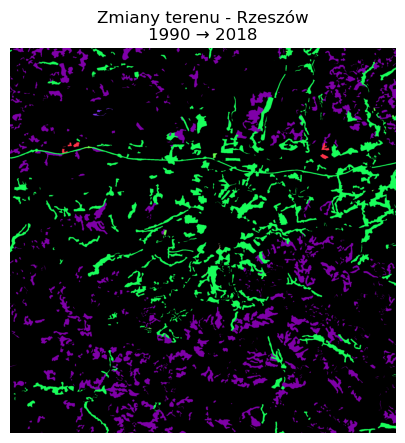

In [39]:
year1 = 1990
year2 = 2018
diff = ImageChops.difference(images_lvl_1[year1],images_lvl_1[year2])
if diff.getbbox():
    fig, ax = plt.subplots(figsize=(10,5))
    ax.imshow(diff)
    ax.axis("off")
    title_name = area_name.replace("_", " ").title()
    ax.set_title(f"Zmiany terenu - {title_name}\n{year1} → {year2}")

In [40]:
def plot_changes(images_dict, year1, year2, title=f"Zmiany użytkowania terenu"):
    img1 = images_dict[year1].convert("RGB")
    img2 = images_dict[year2].convert("RGB")

    # Zamiana na numpy array
    img1_array = np.array(img1)
    img2_array = np.array(img2)

    assert img1_array.shape == img2_array.shape, "Obrazy muszą mieć te same wymiary!"

    # Maska zmian
    changes_mask = np.any(img1_array != img2_array, axis=2)

    # Tworzymy obraz różnicowy
    change_map = np.zeros_like(img1_array)
    change_map[changes_mask] = [255, 0, 0]  # Zmiany na czerwono

    plt.figure(figsize=(6, 6))
    plt.imshow(change_map)
    plt.title(f"{title}\n{year1} → {year2}")
    plt.axis("off")
    plt.show()

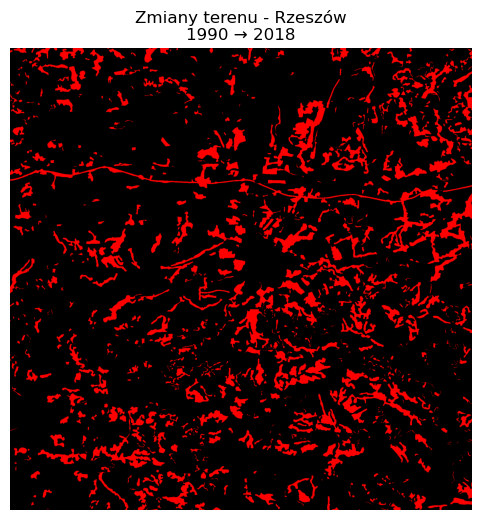

In [41]:
title = "Zmiany terenu - " + area_name.replace("_", " ").title()
plot_changes(images_lvl_1,1990,2018, title)

## Analiza trendu przemian powierzchni

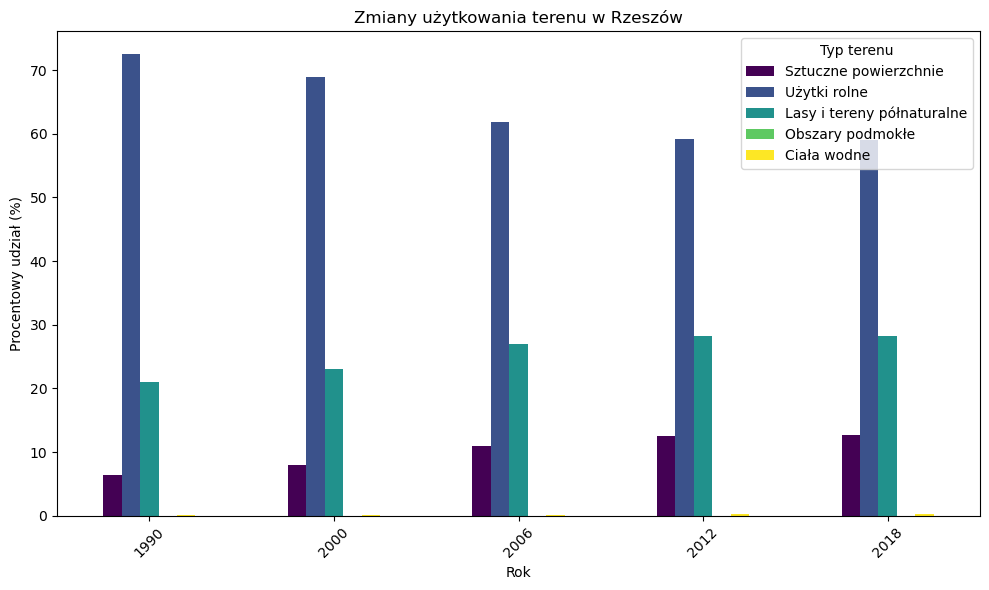

In [43]:
trend_df = []
for year ,df in dfs.items():
    counts = df['class_lvl_1'].value_counts(normalize=True) * 100
    row = {
        "Year": year,
        "Sztuczne powierzchnie": counts.get("1 - Sztuczne powierzchnie", 0),
        "Użytki rolne": counts.get("2 - Użytki rolne", 0),
        "Lasy i tereny półnaturalne": counts.get("3 - Lasy i tereny półnaturalne", 0),
        "Obszary podmokłe": counts.get("4 - Obszary podmokłe", 0),
        "Ciała wodne": counts.get("5 - Ciała wodne", 0)
    }
    trend_df.append(row)
trend_df = pd.DataFrame(trend_df).set_index("Year")
trend_df.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title(f"Zmiany użytkowania terenu w {area_name.replace('_', ' ').title()}")
plt.xlabel('Rok')
plt.ylabel('Procentowy udział (%)')
plt.xticks(rotation=45)
plt.legend(title='Typ terenu')
plt.tight_layout()
plt.show()

In [44]:
def calculate_land_use_trend(dfs, class_column, area_name, show_plot=True,show_percent=True):
    trend = []

    for year, df in dfs.items():
        counts = df[class_column].value_counts(normalize=True) * 100  # procenty
        row = {"Year": year}
        for class_label, percent in counts.items():
            row[class_label] = percent
        trend.append(row)

    trend_df = pd.DataFrame(trend).set_index("Year").fillna(0).sort_index(axis=1)

    if show_plot:
        ax = trend_df.plot(kind='bar', figsize=(12, 6), colormap='viridis')

        # Dodaj wartości liczbowo nad każdym 
        if show_percent:
            for container in ax.containers:
                ax.bar_label(container, fmt='%.1f%%', fontsize=8, label_type='edge',rotation=45)

        plt.title(f"Zmiany użytkowania terenu w {area_name.replace('_', ' ').title()}")
        plt.xlabel("Rok")
        plt.ylabel("Udział (%)")
        plt.xticks(rotation=45)
        plt.legend(title="Typ terenu", bbox_to_anchor=(1.05, 1), loc='upper left')
        #plt.tight_layout()
        ax.grid(True)
        plt.show()
    


    return trend_df

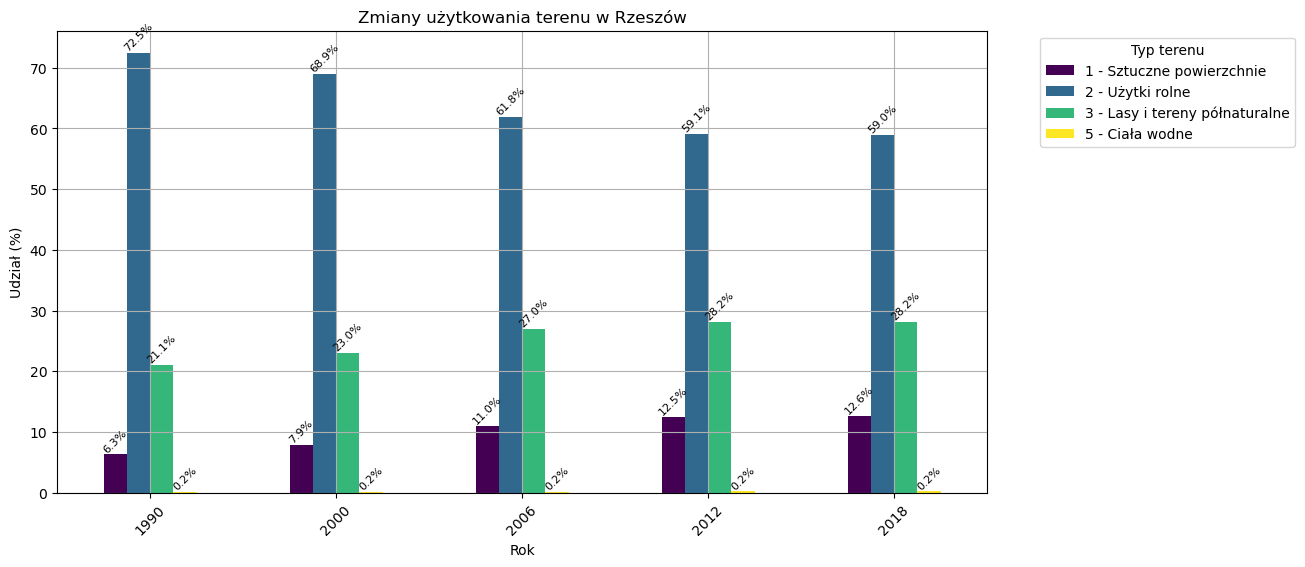

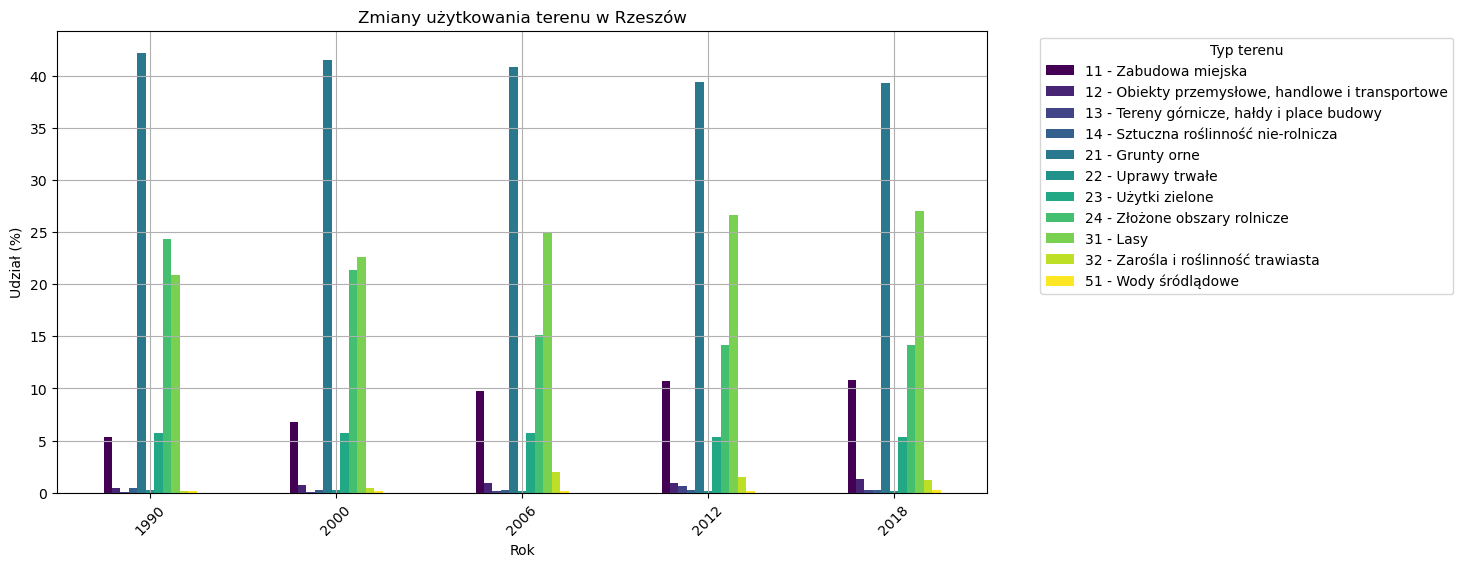

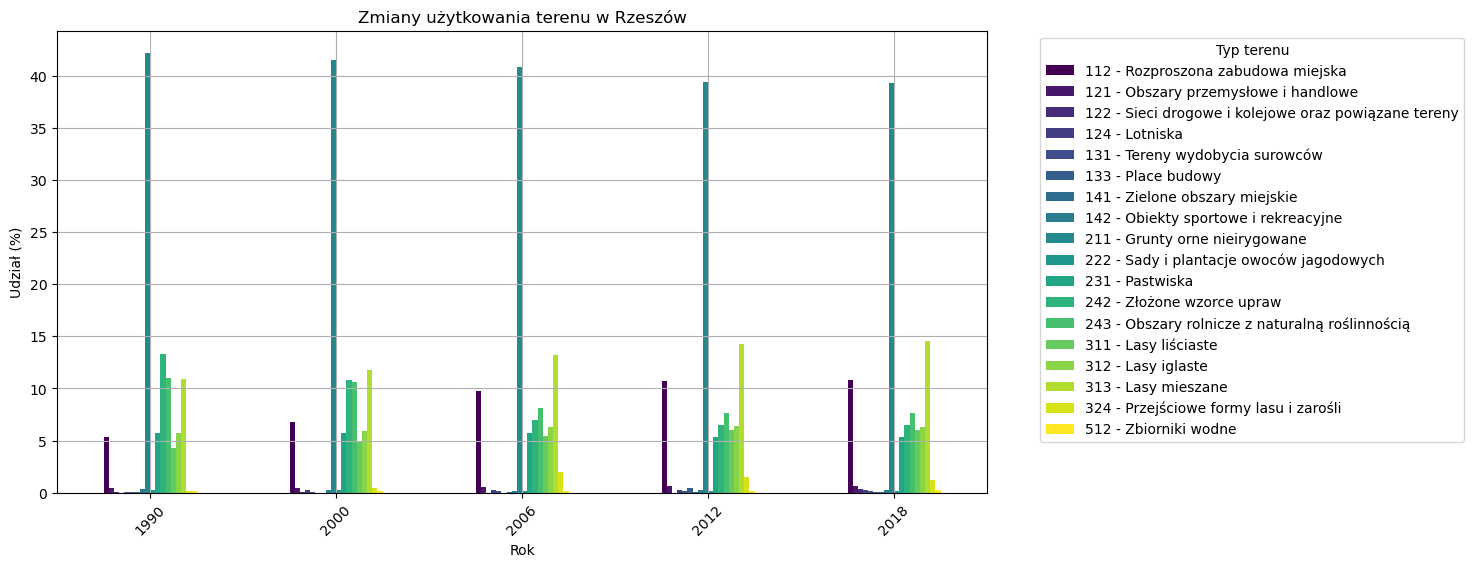

In [45]:
trend_lvl1 = calculate_land_use_trend(dfs, class_column='class_lvl_1', area_name=area_name,show_percent=True)
trend_lvl2 = calculate_land_use_trend(dfs, class_column='class_lvl_2', area_name=area_name,show_percent=False)
trend_lvl3 = calculate_land_use_trend(dfs, class_column='class', area_name=area_name,show_percent=False)

## Określenie ilości zmian w występowaniu "wysp" -  odrębnych poligonów danego typu terenu.

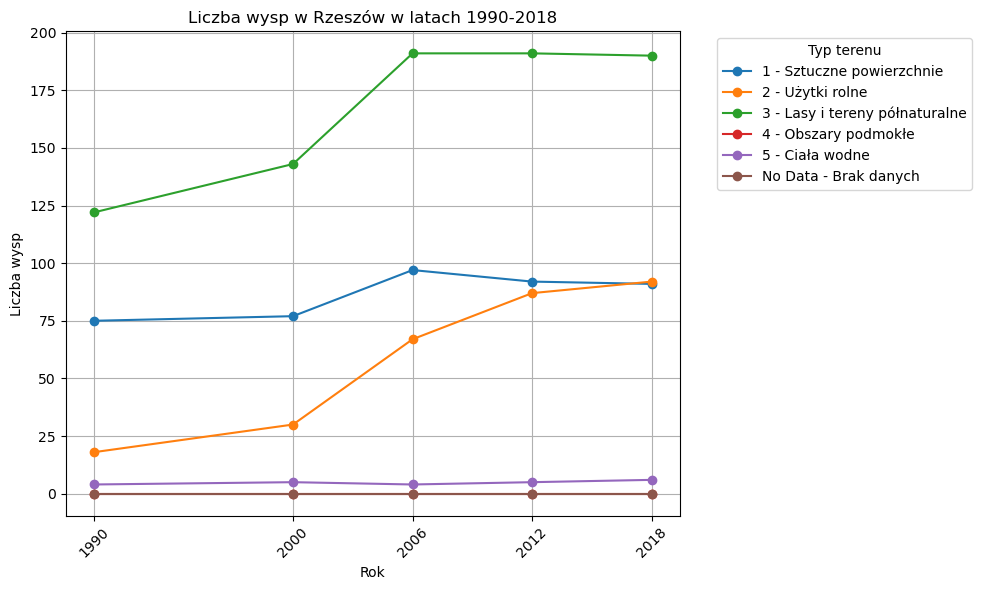

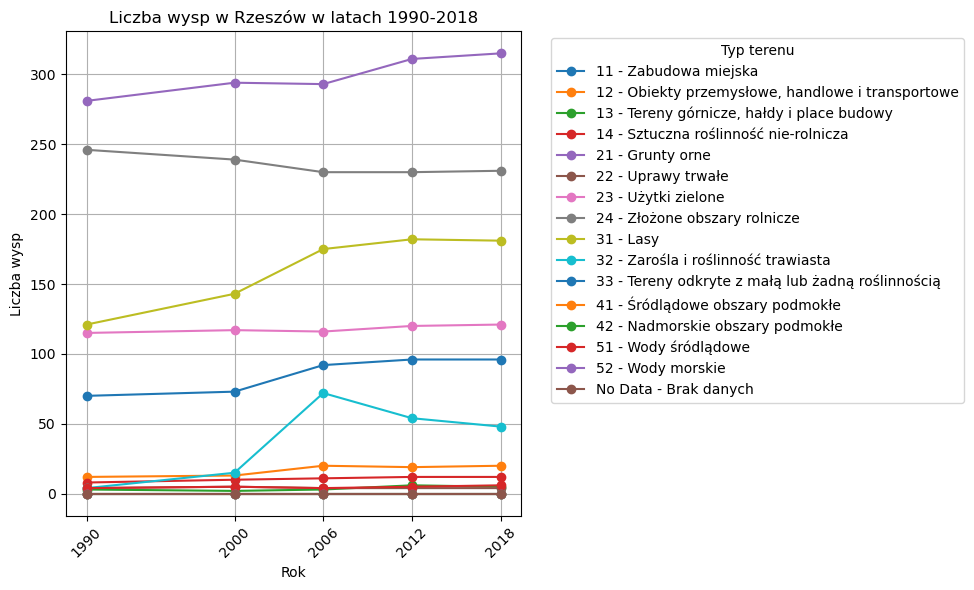

In [47]:
def seperate_classes (level_classes, years, dfs,class_lvl):
    results = []

    for level_type in level_classes:
        for year in years:
            df = dfs[year]

            height = df['y'].max() + 1
            width = df['x'].max() + 1

            mask = np.zeros((height, width), dtype=np.uint8)
            x = df['x'].to_numpy()
            y = df['y'].to_numpy()
            classes = df[class_lvl].to_numpy()
            mask[y, x] = (classes == level_type).astype(np.uint8)

            labeled, num_features = label(mask)
            results.append({
                "year": year,
                "class": level_type,
                "count": num_features
            })

    data =pd.DataFrame(results)
    df_islands_pivot = data.pivot(index='year', columns='class', values='count')
    df_islands_pivot.plot(kind='line', figsize=(10, 6), marker='o')
    plt.title(f"Liczba wysp w {area_name.replace('_', ' ').title()} w latach {years[0]}-{years[-1]}")
    plt.xlabel("Rok")
    plt.ylabel("Liczba wysp")
    plt.xticks(years, rotation=45)
    plt.legend(title="Typ terenu", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show() 

df_islands_1 = seperate_classes(level_1_legend_desc.values(), years, dfs,"class_lvl_1")
df_islands_2= seperate_classes(level_2_legend_desc.values(), years, dfs,"class_lvl_2")


C:\Users\micha\AppData\Local\Temp\ipykernel_29624\2196807280.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["class_lvl_1_2006"] = temp3["class_lvl_1"]
C:\Users\micha\AppData\Local\Temp\ipykernel_29624\2196807280.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["class_lvl_1_2018"] = temp2["class_lvl_1"]
C:\Users\micha\AppData\Local\Temp\ipykernel_29624\2196807280.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``ma

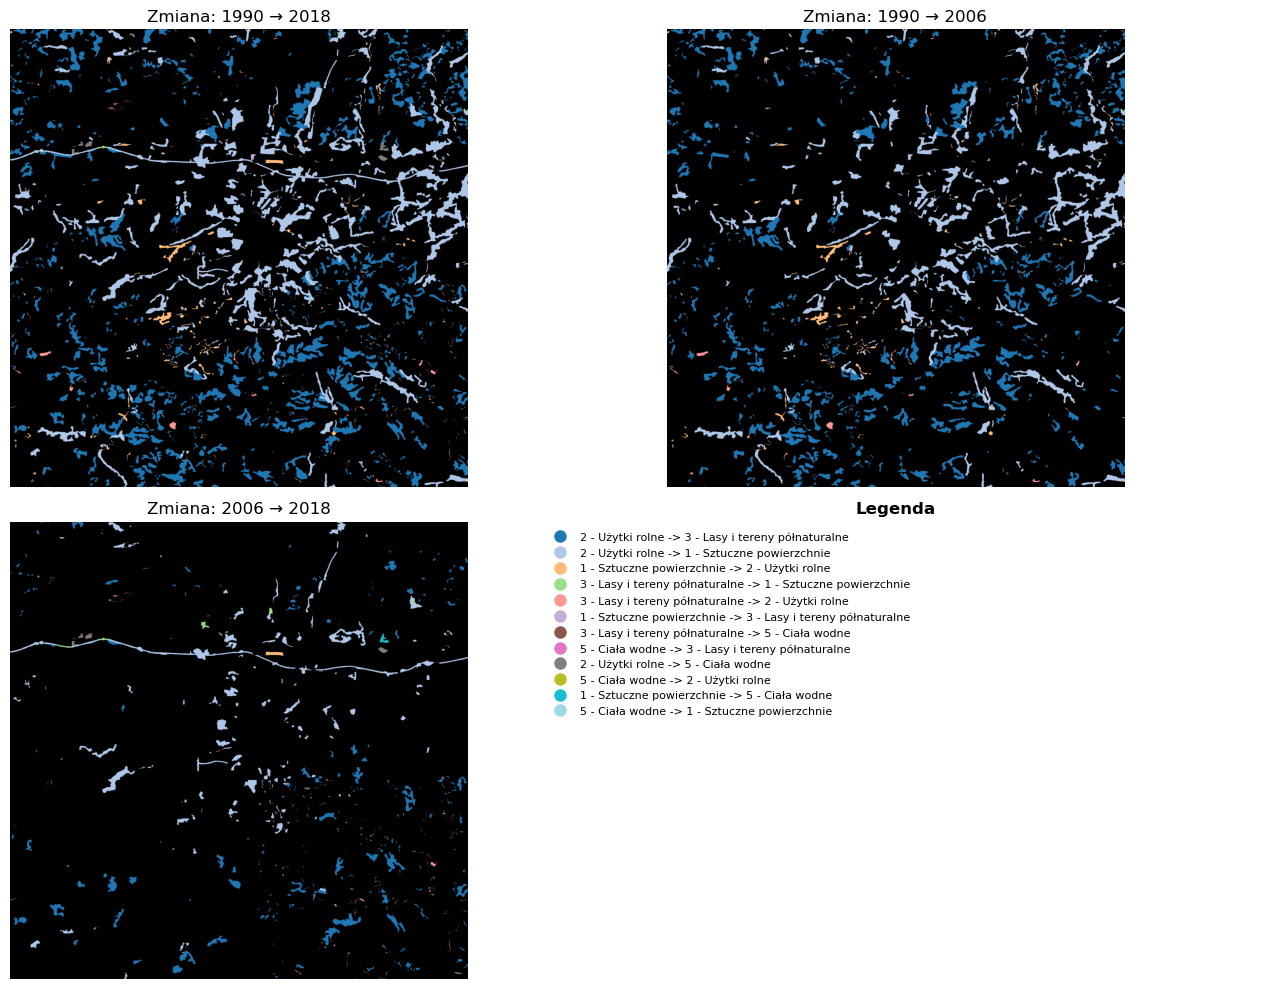

In [48]:
temp1 = dfs[1990]
temp2 = dfs[2018]
temp3 = dfs[2006]

temp = temp1.iloc[:, [0, 1, 10]]
temp["class_lvl_1_2006"] = temp3["class_lvl_1"]
temp["class_lvl_1_2018"] = temp2["class_lvl_1"]

temp = temp[temp["class_lvl_1_2018"] != temp["class_lvl_1"]]

temp["join"] = temp["class_lvl_1"] + ' -> ' + temp["class_lvl_1_2018"]
temp["join6"] = temp["class_lvl_1"] + ' -> ' + temp["class_lvl_1_2006"]
temp["join18"] = temp["class_lvl_1_2006"] + ' -> ' + temp["class_lvl_1_2018"]

temp6 = temp[temp["class_lvl_1_2006"] != temp["class_lvl_1"]]
temp18 = temp[temp["class_lvl_1_2018"] != temp["class_lvl_1_2006"]]

unique_values = pd.unique(pd.concat([temp['join'], temp6['join6'], temp18['join18']]))
n = len(unique_values)
cmap = cm.get_cmap('tab20', n)
color_map = {val: tuple((np.array(cmap(i)[:3]) * 255).astype(int)) for i, val in enumerate(unique_values)}

temp['color'] = temp['join'].map(color_map)
temp6['color6'] = temp6['join6'].map(color_map)
temp18['color18'] = temp18['join18'].map(color_map)

width = temp['x'].max() + 1
height = temp['y'].max() + 1
x = temp['x'].to_numpy()
y = temp['y'].to_numpy()

width6 = temp6['x'].max() + 1
height6 = temp6['y'].max() + 1
x6 = temp6['x'].to_numpy()
y6 = temp6['y'].to_numpy()

width18 = temp18['x'].max() + 1
height18 = temp18['y'].max() + 1
x18 = temp18['x'].to_numpy()
y18 = temp18['y'].to_numpy()

def make_image(rgb_values, x, y, height, width):
    img = np.zeros((height, width, 3), dtype=np.uint8)
    img[y, x] = np.stack(rgb_values)
    return PILImage.fromarray(img, mode='RGB')

image1 = make_image(temp['color'], x, y, height, width)    # 1990 → 2018
image6 = make_image(temp6['color6'], x6, y6, height6, width6)   # 1990 → 2006
image18 = make_image(temp18['color18'], x18, y18, height18, width18) # 2006 → 2018

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].imshow(image1)
axs[0, 0].set_title("Zmiana: 1990 → 2018")
axs[0, 0].axis("off")

axs[0, 1].imshow(image6)
axs[0, 1].set_title("Zmiana: 1990 → 2006")
axs[0, 1].axis("off")

axs[1, 0].imshow(image18)
axs[1, 0].set_title("Zmiana: 2006 → 2018")
axs[1, 0].axis("off")

ax_legend = axs[1, 1]
ax_legend.axis("off")
ax_legend.set_title("Legenda", fontsize=12, fontweight='bold')

legend_items = pd.unique(pd.concat([temp['join'], temp6['join6'], temp18['join18']]))
legend_patches = [
    mlines.Line2D([0], [0], marker='o', color='w', markersize=10,
                  markerfacecolor=np.array(color_map[label]) / 255.0, label=label)
    for label in legend_items
]

ax_legend.legend(handles=legend_patches, loc="upper left", fontsize=8, frameon=False)

plt.tight_layout()
plt.show()